In [1]:
import os
import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels

In [3]:
all_file='Input_data/Proteomic data/abundance/Norm_Intensity_Bovsynth022123.xlsx'
raw_MS_data=pd.read_excel(all_file,header=0)
col_length=raw_MS_data.shape[0]
to_drop=[]
for i in raw_MS_data.columns:
    column=raw_MS_data[i]
    zeros=(column==0).sum()
    # print(zeros)
    # print(zeros)
    # print(raw_MS_data[i])
    if zeros>int(col_length/2):
        to_drop.append(i)
        # print(raw_MS_data.shape[1])
# print(raw_MS_data.shape[1])
print(to_drop)
raw_MS_data.drop(columns=to_drop,inplace=True)

[31, 32, 33, 34, 35, 36, 37, 38, 44, 45, 46, 47, 48, 49, 50, 'Unnamed: 26']


In [2]:
# Pull together Proteomic data
in_dir="Input_data/Proteomic data/abundance/"
# prot_abund_file='Input_data/Proteomic data/abundance/Norm_Intensity_Bovsynth022123.xlsx'
prot_abund_file='Input_data/Proteomic data/abundance/Intensity _all20230202.xlsx'
NP_filepath='Input_data/NPs/NP_Database.xlsx'
#combine Mass Spec data input into one excel spreadsheet - Entry - Abundance labeled by NP Unique ID
#Abundance as a percent
#take files in_dir and combine then into one pandas df (raw_MS_data) ###USE when combining multiple datasets####
# files = os.listdir(in_dir)
# for i,f in enumerate(files):
#     if i==0:
#         raw_MS_data=pd.read_excel(in_dir+f,header=0)
#     else:
#         temp = pd.read_excel(in_dir+f,header=0)
#         raw_MS_data=raw_MS_data.merge(temp,how='outer',on='Entry')
raw_MS_data=pd.read_excel(prot_abund_file,header=0)
#drop samples that are missing more than half of the proteins in their file, dont use this section currently
# col_length=raw_MS_data.shape[0]
# to_drop=[]
# for i in raw_MS_data.columns:
#     column=raw_MS_data[i]
#     zeros=(column==0).sum()
#     if zeros>int(col_length/2):
#         to_drop.append(i)
# raw_MS_data.drop(columns=to_drop,inplace=True)
# melt the df to make it an accession number, NPUNID, Abundance dataset
raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'],var_name='Sample_num', value_name='Abundance')
#remove prots that were added due to merge
raw_MS_data=raw_MS_data.dropna()
###Bring in controls (MS data for serums)##
controls=pd.read_excel('Input_data/Proteomic data/controls_combined.xlsx',header=0)
MS_data_controls = pd.merge(raw_MS_data,controls,how='left', on='Entry')
###Bring in Uniprot_data,NSPdata and NP data##
uniprot_filepath='Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
uniprot_dat=pd.read_excel(uniprot_filepath,header=0)
NSPfilePath='Input_data/NetSurfP_data/Combined.xlsx'
NSP_data=pd.read_excel(NSPfilePath)
###Bring in NP data and merge to get complete NP dataset###

NPUNdata=pd.read_excel(NP_filepath,header=0,sheet_name='NPUNID')
NPprop=pd.read_excel(NP_filepath,header=0,sheet_name='NP_Props')
NPdata=pd.merge(NPUNdata,NPprop,how="left",on='NPID')
NPdata.dropna(inplace=True)
#calculate Enrichment
#####MAYBE add binning here to keep negative results and improve capapbilities######
# MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
# MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
#keep abundance Controls
# MS_data=MS_data_controls.drop(columns=['Abundance'])
raw_prop_data=pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left',on='Entry')
Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']),how='left', on='Entry') #merges netsurfp features and biopython features
Protein_data_complete.fillna(0,inplace=True)
#creates new column called asa_sum_normalized which is the asa_sum value divide by the mass of the protein
for df in [Protein_data_complete]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']

data_complete= pd.merge(Protein_data_complete,NPdata,how='inner', on='Sample_num')
data_complete.drop(columns=['notes','Notes','NPUNID'],inplace=True)
data_complete.fillna(0,inplace=True)
data_complete= data_complete.replace([-np.inf],'-12')
data_complete=data_complete.replace([np.inf],'12')
#create ordinal variables
# data_complete2=pd.get_dummies(data_complete, columns=['Core Material','Surface_Ligand'])
le=LabelEncoder()
data_complete['Core Material']=le.fit_transform(data_complete['Core Material'])
data_complete['Surface_Ligand']=le.fit_transform(data_complete['Surface_Ligand'])

#set labels (what we are trying to predict) as Enrichment column
# labels=data_complete['Enrichment'].copy()
label_abund=np.ravel(data_complete['Abundance'].copy())
label_abund_df=pd.DataFrame(label_abund)
# label_enrich=np.ravel(data_complete['Enrichment'].copy())
#make it one dimenisional
#drop qualitative, not neccessary, and label columns
#create df without bonus NSP columns (remove total_exposed)
to_drop=data_complete.filter(like='total_exposed_')
data_complete.drop(columns=to_drop,inplace=True)
df=data_complete.drop(['Entry','Abundance','Sequence','NPID','Ligands','Protein Source','Sample_num','Unnamed: 5','Raw_FileID'],axis=1)
# df_enrich=data_complete.drop(['Entry','Abundance','Sequence','NPID','Ligands','Protein Source','Sample_num','Unnamed: 5','Raw_FileID'],axis=1)
df.to_excel("Input_data/Save_files/df_synth.xlsx")
label_abund_df.to_excel("Input_data/Save_files/label_abund_synth.xlsx")
# label_enrich.to_excel("Input_data/Save_files/label_enrich_synth.xlsx")

In [9]:
df_2.to_excel("Input_data/Save_files/df_RFECVall.xlsx")
# label_abund_df.to_excel("Input_data/Save_files/label_abund_all.xlsx")

In [6]:
df_2=pd.read_excel("Input_data/Save_files/df_synth_RFECV.xlsx")
df_2.drop(columns=['Unnamed: 0'],inplace=True)
label_df=pd.read_excel("Input_data/Save_files/label_abund_synth.xlsx")
label_abund=np.ravel(label_df[0])
print(label_abund.shape)
print(df_2.shape)

(7562,)
(7562, 9)


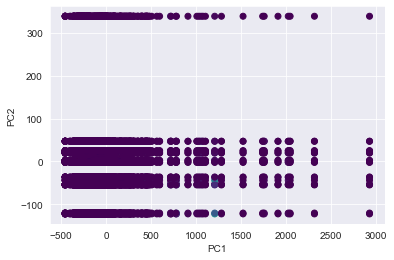

In [15]:
#Run PCA to seee how data differentiates#
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
x_pca=pca.fit_transform(df_2)

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=label_abund, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('Output_data/PCA_RFECV.png')
plt.show()

In [ ]:
#Remove correlated features (over r2 threshold level) and output reduced dataframe (df2)# ##Maybe use in future##
# corr_matrix = df.corr()
# threshold = 0.8
# correlated_features = set()
#
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if threshold < abs(corr_matrix.iloc[i, j]) < 1:
#             colname = corr_matrix.columns[i]
#             correlated_features.add(colname)
# correlated_features
# df_2=df.drop(columns=correlated_features)

In [5]:
#use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
step=2
feats=45
estimator=RandomForestRegressor(n_estimators=100)
selector = RFE(estimator, n_features_to_select=feats, step=step)
selector = selector.fit(df, label_abund)
selector.support_
ranking=selector.ranking_
feat_list = selector.get_feature_names_out()
df_rfe=df[feat_list]
feat_list

array(['Abundance_Controls', 'Length', 'Mass', 'frac_aa_C', 'frac_aa_D',
       'frac_aa_F', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M',
       'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V',
       'molecular_weight', 'instability_index', 'flexibility_max',
       'flexibility_min', 'secondary_structure_fraction_helix',
       'secondary_structure_fraction_disordered', 'gravy', 'rsa_median',
       'rsa_std', 'fraction_exposed_exposed_A',
       'fraction_exposed_exposed_E', 'fraction_exposed_exposed_H',
       'fraction_exposed_exposed_L', 'fraction_exposed_exposed_N',
       'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T',
       'fraction_exposed_exposed_Y', 'nsp_secondary_structure_coil',
       'nsp_secondary_structure_sheet', 'nsp_secondary_structure_helix',
       'nsp_disordered', 'Zeta Potential', 'Ligand_PVP', 'Ligand_Au',
       'Surface_Ligand', 'Dtem', 'Dh_core', 'Dh_functionalized',
       'Incubation Concentration (mg/ml)', 'Corona_Co

In [6]:
ranking

array([ 1,  1,  1,  9,  1,  1, 12,  1,  7,  7,  1,  1,  1,  1,  5, 16,  1,
        1,  1,  1,  1, 15,  6,  1, 10,  1, 16,  9,  3,  1,  1, 11, 20,  1,
       18,  5,  1,  1, 19,  8, 21, 18,  4, 17, 20,  1,  1,  2,  1, 17, 13,
        1, 15, 19,  1, 12, 14,  1,  4,  1,  6,  3, 10,  1,  1,  8, 11,  1,
        1,  1,  1,  1, 14, 26,  1, 21, 22, 22, 23, 24, 13,  2,  1,  1,  1,
        1,  1,  1, 23, 24, 25,  1,  1, 25, 26])

In [7]:
#run Recursive feature elimination with cross validation
from sklearn.model_selection import KFold
step=1
min_feats=1
cv= KFold(n_splits=10)
estimator=RandomForestRegressor(n_estimators=100)
# estimator=Lasso(alpha=.05)
selector = RFECV(estimator=estimator, cv=cv, scoring='neg_mean_squared_error', min_features_to_select=min_feats, step=step)
selector = selector.fit(df_rfe, label_abund)
selector.support_
feat_list2 = selector.get_feature_names_out()
selected_features= df_rfe.columns[selector.support_]

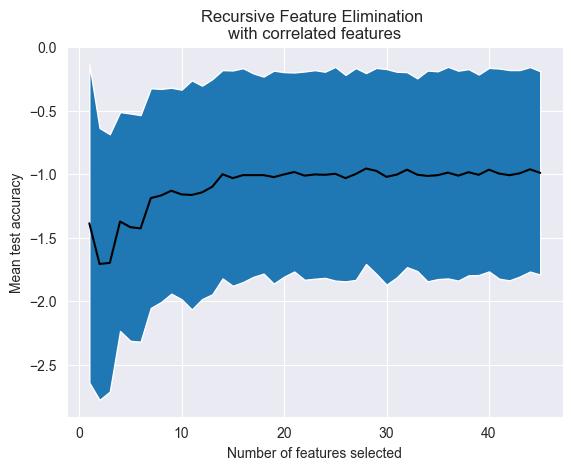

In [8]:
df_2=df[feat_list2]
n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
x=range(1, n_scores + 1)
y=selector.cv_results_["mean_test_score"]
err=selector.cv_results_["std_test_score"]
plt.plot(x,y,'k-')
plt.fill_between(x,y-err,y+err)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.savefig('Output_data/RFECV45_all.png')
plt.show()


In [ ]:
rfecv_df=pd.DataFrame(selector.cv_results_)
rfecv_df.to_excel("Output_data/RFECV_data.xlsx")
feat_list2
df_2.to_excel("Input_data/Save_files/df_synth_RFECV.xlsx")

In [ ]:
#try using a meta model including a linear model and Random Forest Model#
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import mean_squared_error
#
#
#
# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(df_rfe, label_abund, test_size=0.2, random_state=42)
#
# # Create the base models
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# ridge = Ridge(alpha=0.1, random_state=42)
#
# rf_model = rf.fit(X_train,y_train)
# ridge_model = ridge.fit(X_train,y_train)
# # Make predictions with the base models
# rf_pred = cross_val_predict(rf_model, X_train, y_train, cv=5)
# ridge_pred = cross_val_predict(ridge_model, X_train, y_train, cv=5)
#
# # Create the input for the meta-model
# stacking_input = np.column_stack((rf_pred, ridge_pred))
#
# # Train the meta-model (ridge regression)
# meta_model = Ridge(alpha=1.0, random_state=42)
# meta_model.fit(stacking_input, y_train)
#
# # Make predictions with the meta-model
# rf_pred_test = rf_model.predict(X_test)
# ridge_pred_test = ridge_model.predict(X_test)
# stacking_input_test = np.column_stack((rf_pred_test, ridge_pred_test))
# y_pred_test = meta_model.predict(stacking_input_test)
#
# # Evaluate the performance of the stacked model
# mse = mean_squared_error(y_test, y_pred_test)
# print("MSE: {:.2f}".format(mse))


In [ ]:
#test estimator to see what is the ideal number of estimators
# estimators=np.arange(5,500,5)
# out_name=np.arange(5,500,5)
# # print(out_name)
# scores=[]
# x_train, x_test, y_train, y_test = train_test_split(df_abund, label_abund,
#                                                         test_size=0.2,
#                                                         random_state=42)
#
# for i in range(len(estimators)):
#     rfg = RandomForestRegressor(n_estimators=estimators[i])
#     rfg.fit(x_train, y_train)
#     score=rfg.score(x_test,y_test)
#     scores.append(score)
# a=pd.DataFrame(list(zip(estimators,scores)), columns=['number of estimators','accuracy'])
# a.to_excel("Output_data/estimators_score_abund.xlsx")

In [8]:
print(x_test.columns)

Index(['Abundance_Controls', 'Length', 'secondary_structure_fraction_sheet',
       'fraction_exposed_exposed_H', 'fraction_exposed_exposed_P',
       'nsp_secondary_structure_helix', 'Zeta Potential', 'Dh_functionalized',
       'NP_incubation Concentration (mg/mL)'],
      dtype='object')


In [13]:
#look at loss as a function of feature
feats=[]
scores=[]
df=df_2
id='_RFECV'
label=label_abund
# frames=['df','df_norm','df_NSP_drop']
# for x,i in enumerate(df_listnew):\

x_train, x_test, y_train, y_test = train_test_split(df,label, test_size = 0.2, random_state=42)
rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
topscore=rfr.score(x_test,y_test)
importances=rfr.feature_importances_*100
scores.append(topscore)
feats.append('allfeats')
importances=np.insert(importances,[0],0)
for j in x_test.columns:
    tmp=x_test.copy()
    # print(x_test)
    np.random.shuffle(tmp[j].values)
    scram_score=rfr.score(tmp,y_test)
    scores.append(scram_score)
    feats.append(j)

a=pd.DataFrame(list(zip(feats,scores,importances)),columns=['feat','score','importances'])
a.to_excel("Output_data/scram_loss_feats"+id+".xlsx")



In [ ]:
##Fit and predict after dropping the next least loss feature, drop one feature at a time
x_train, x_test, y_train, y_test = train_test_split(df_2,label_abund, test_size = 0.2, random_state=42)
feats=[]
scores=[]

rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
topscore=rfr.score(x_test,y_test)
a=list(zip(rfr.feature_importances_,rfr.feature_names_in_))
a.sort(reverse=True)
col_import=pd.DataFrame(a,columns=['importances','names'])
sorted_cols=col_import['names']
feats.append('topscore')
scores.append(topscore)

#df_3=df_2.copy()
for i in sorted_cols:
    df_3=df_2.copy() #remove if you only want to drop each feature instead of dropping one feature at a time
    df_3.drop(columns=[i],inplace=True)
    x_train, x_test, y_train, y_test = train_test_split(df_3,label_abund, test_size = 0.2, random_state=42)
    rfr.fit(x_train,y_train)
    score=rfr.score(x_test,y_test)
    scores.append(score)
    feats.append(i)

df_out=pd.DataFrame(list(zip(feats,scores)),columns=['dropped feat','score without feat'])
df_out.to_excel("Output_data/scores_afterdrop.xlsx")

In [ ]:
##Fit and predict after dropping the next least loss feature, drop one feature at a time cumulative
x_train, x_test, y_train, y_test = train_test_split(df_2,label_abund, test_size = 0.2, random_state=42)
feats=[]
scores=[]

rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
topscore=rfr.score(x_test,y_test)
a=list(zip(rfr.feature_importances_,rfr.feature_names_in_))
a.sort(reverse=True)
col_import=pd.DataFrame(a,columns=['importances','names'])
sorted_cols=col_import['names']
feats.append('topscore')
scores.append(topscore)

df_3=df_2.copy()
for i in sorted_cols:
    if i == sorted_cols.iloc[-1]:
        break
    # df_3=df_2.copy() #remove if you only want to drop each feature instead of dropping one feature at a time
    df_3.drop(columns=[i],inplace=True)
    x_train, x_test, y_train, y_test = train_test_split(df_3,label_abund, test_size = 0.2, random_state=42)
    rfr.fit(x_train,y_train)
    score=rfr.score(x_test,y_test)
    scores.append(score)
    feats.append(i)

df_out=pd.DataFrame(list(zip(feats,scores)),columns=['dropped feat','score without feat'])
df_out.to_excel("Output_data/scores_afterdrop_cumulative_reverse.xlsx")

In [ ]:
# plot predictions with prediction accuracies#

In [14]:
#look at pearson correlation of predictions#
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(df_2,label_abund, test_size = 0.2, random_state=42)

rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
predictions=rfr.predict(x_test)
r2=r2_score(y_test, predictions)
corr,_ = pearsonr(y_test, predictions)

print(r2)
print(corr)



0.6580032078152742
0.8121382250361637


In [9]:
#look at pearson correlation of predictions#
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(df_2,label_abund, test_size = 0.2, random_state=42)

rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
predictions=rfr.predict(x_test)
r2=r2_score(y_test, predictions)
corr,_ = pearsonr(y_test, predictions)

print(r2)
print(corr)



0.6064262306745349
0.7791496130816059
